<a href="https://colab.research.google.com/github/claree007/Customer-Churn/blob/master/Customer_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Customer Churn</h1>



In [0]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve

%matplotlib inline

<h2>Importing the data</h2>

In [0]:
# load the data
path_to_file = "Churn.csv"
customers = pd.read_csv(path_to_file)

customers.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


<h2>Understand the data</h2>

1. First we check the data type of our columns and any missing/null fields.

In [0]:
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

Thie TotalCharges field should have been a numerical attribute but here it is an object.


2. In real life, people tend to leave a service if they are charged a high amount of money without them knowing(happens mostly with postpaid subcriptions). So I will check if people who were charged the highest left the service.

In [0]:
# we will work on a copy of the data rather than overwrite the original
changed_customers = customers.copy()

# convert TotalCharges to numerical attribute and fill missing values with mean
changed_customers["TotalCharges"] = changed_customers["TotalCharges"].apply(pd.to_numeric, errors='coerce')
changed_customers["TotalCharges"].fillna(changed_customers["TotalCharges"].mean(), inplace=True)

# convert Churn to numerical attribute
#changed_customers["Churn"] = changed_customers["Churn"].astype('int')
changed_customers["Churn"] = pd.get_dummies(changed_customers["Churn"])
changed_customers["Churn"] = (changed_customers["Churn"].astype('int64') - 1).abs()

# ratio of customers who paid less and left
paid_less_left = changed_customers.loc[(changed_customers['Churn'] >= 1) & (changed_customers['TotalCharges'] <= 500)]
paid_less = changed_customers.loc[changed_customers['TotalCharges'] <= 500]
print("Ratio of customers who paid less and left: {0:1.3f}".format(len(paid_less_left)/ len(paid_less)))

# ratio of customers who paid high and left
paid_high_left = changed_customers.loc[(changed_customers['Churn'] >= 1) & (changed_customers['TotalCharges'] >= 7000)]
paid_high = changed_customers.loc[changed_customers['TotalCharges'] >= 7000]
print("Ratio of customers who paid high and left: {0:1.3f}".format(len(paid_high_left)/ len(paid_high)))

Ratio of customers who paid less and left: 0.414
Ratio of customers who paid high and left: 0.101


In [0]:
changed_customers['tenure'].mean()

32.37114865824223

In [0]:
changed_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null int64
dtypes: float64(2), int64(3), obj

<h2>Data Manipulation</h2>


Splitting the data into train and test sets

In [0]:
customers["TotalChargesCategory"] = pd.cut(changed_customers["TotalCharges"],
                       bins=[0., 500., 1000., 3000., 5000., np.inf],
                       labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_index in split.split(customers, customers["TotalChargesCategory"]):
    customers_train_set = customers.loc[train_index]
    customers_test_set = customers.loc[test_index]
    
for set_ in (customers_train_set, customers_test_set):
    set_.drop("TotalChargesCategory", axis=1, inplace=True)
    
print("Training set size:", len(customers_train_set))
print("Test set size:", len(customers_test_set))

Training set size: 4225
Test set size: 2818


Cleaning the data and filling missing values

In [0]:
class ConvertToNumeric(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        s = X.values.shape[1]
        return X.apply(pd.to_numeric, errors='coerce')
        
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

In [0]:
# seperate categorical attributes
num_attr = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]

# we will process bool and no_bool attributes seperately
bool_cat_attr = ["gender", "Partner", "Dependents", "PhoneService",
                 "OnlineSecurity", "OnlineBackup", "DeviceProtection",
                 "TechSupport", "StreamingTV", "StreamingMovies",
                 "PaperlessBilling"]
other_cat_attr = ["MultipleLines", "InternetService", "Contract", "PaymentMethod"]

label = ["Churn"]

# pipeline for numerical attributes
num_pipeline = Pipeline([
    ("convert_obj", ConvertToNumeric()),
    ("imputer", SimpleImputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

# full pipeline
final_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attr),
    ("bool_cat", OrdinalEncoder(), bool_cat_attr),
    ("other_cat", OneHotEncoder(), other_cat_attr),
    ("lab_bin", LabelBinarizerPipelineFriendly(), label)
])

customers_prepared = final_pipeline.fit_transform(customers_train_set)
print(customers_prepared[0])   

[ 2.26540846 -0.83253026 -0.69553418 -0.77317593  1.          0.
  0.          0.          0.          0.          2.          2.
  0.          2.          1.          0.          1.          0.
  1.          0.          0.          1.          0.          0.
  0.          0.          1.          0.          1.        ]


<h2>Data Visualization</h2>

Correlation can tell us which features are important in predicting the label

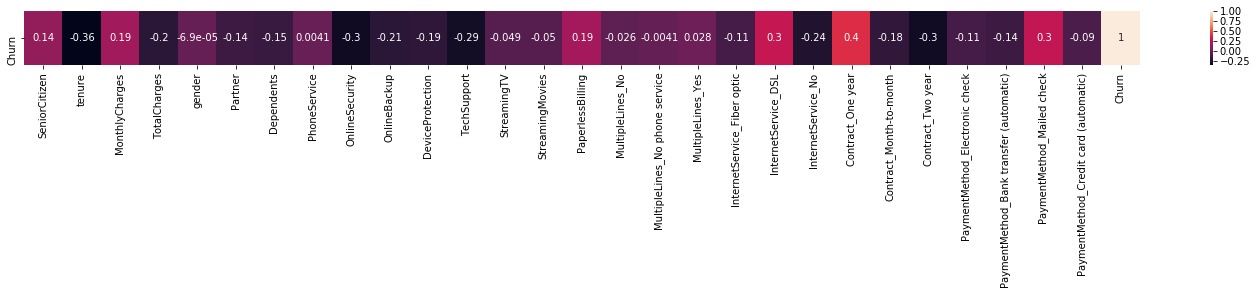

In [0]:
# rename the columns after transformation
cols = num_attr + bool_cat_attr
for col in other_cat_attr:
    cats = set(customers[col])
    for cat in cats:
        col_name = col + '_' + cat
        cols.append(col_name)
cols.append(''.join(label))

# plot the correlation of Churn with other attributes
customers_vis = pd.DataFrame(customers_prepared, columns=cols)
correlation = customers_vis.corr()
#print(cols[(correlation.loc[['Churn'],:] <= 0.05).values])
fig = plt.figure(figsize=(25, 1))
fig = sns.heatmap(correlation.loc[['Churn'],:], annot=True)

Looking at the above data we can see that the attributes that correspond to numbers close to 0 are not very useful to us. So we can remove them which will help in speeding up our training.

In [0]:
# remove gender, PhoneService and MultipleLines_NoPhoneService attributes
customers_prepared = np.delete(customers_prepared, [4, 7, 16], axis=1)
customers_prepared.shape

(4225, 22)

The key factors that predict Churn are tenure, OnlineSecurity, TechSupport, InternetService_DSL, contract and payment method. Most of these make sense: those who have a high tenure/contract are likely to not leave and the other way round . OnlineSecurity and Techsupport are things which the company needs to work on because they are likely to cause the customers to leave.

**The company should lower the prices of monthly subscriptions. Also Online security and tech support are things which they need to improve.**

<h2>Implement Machine Learning Models</h2>

In [0]:
def grid_search_cv(model, param_grid={}):
    start = time.time()
    grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1,
                               scoring='accuracy',
                               return_train_score=True, error_score=0.0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            grid_search.fit(X_train, y_train)
        except:
            pass
    end = time.time()
    print("Time taken:", end-start)
    try:
        return grid_search.best_estimator_, grid_search.best_score_
    except:
        print("No model found!!")
        return None

X_train = customers_prepared[:, :-1]
y_train = customers_prepared[:, -1]

best_models = []
accuracies = []

1. SGDClassifier

In [0]:
sgd_clf = SGDClassifier()

param_grid = {'loss': ['squared_hinge', 'log', 'hinge'],
              'penalty': ['l1', 'l2', 'elasticnet'],
              'alpha': [0.01, 0.3, 0.1, 0.03, 0.003],
              'l1_ratio': [0.5, 0.3, 0.7],
              'max_iter': [5000],
              'n_jobs': [-1],
              'learning_rate': ['adaptive', 'constant'],
              'eta0': [0.01, 0.03, 0.1, 0.3],
              'power_t': [0.1, 0.01],
              'early_stopping': [True]}

model, acc = grid_search_cv(sgd_clf, param_grid)
print(acc)
best_models.append(model)
accuracies.append(acc)

Time taken: 617.7701663970947
0.8037869822485207


2. K Nearest Neighbors

In [0]:
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [20],
              'weights': ['uniform'],
              'algorithm': ['ball_tree'],
              'leaf_size': [20],
              'p': [3],
              'n_jobs': [-1]}

model, acc = grid_search_cv(knn, param_grid)
print(acc)
best_models.append(model)
accuracies.append(acc)

Time taken: 42.457690954208374
0.7673372781065089


3. SVM Classifier

In [0]:
svc = SVC()

param_grid = {'C': [0.2, 0.5, 1.0],
              'kernel': ['poly', 'rbf'],
              'degree': [2, 3, 4],
              'gamma': [0.1, 0.01, 0.3],
              'coef0': [0.0, 0.1, 0.001],
              'max_iter': [2000]}

model, acc = grid_search_cv(svc, param_grid)
print(acc)
best_models.append(model)
accuracies.append(acc)

Time taken: 363.7709012031555
0.7952662721893491


4. Random Forests

In [0]:
rf_clf = RandomForestClassifier()

param_grid = {'n_estimators': [8, 12],
              'criterion': ['gini'],
              'max_depth': [10, 15],
              'min_samples_split': [2],
              'min_samples_leaf': [2],
              'max_features': [15, 20],
              'max_leaf_nodes': [30, 50],
              'bootstrap': [True, False],
              'n_jobs': [-1],
              'warm_start': [False]}

model, acc = grid_search_cv(rf_clf, param_grid)
print(acc)
best_models.append(model)
accuracies.append(acc)

Time taken: 12.988487482070923
0.7959763313609467


<h2>Model Evaluation</h2>

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.title("PR vs Threshold")
    plt.legend()
    plt.show()

def precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

def yscores(model, X, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            return cross_val_predict(model, X, y, cv=3, method="decision_function")
        except:
            y_probas = cross_val_predict(model, X, y, cv=3, method="predict_proba")
            return (y_probas[:, 1] >= 0.4)*1
    print("None worked!!")
    return None
    
def plot_roc_curve(fpr_s, tpr_s, labels=None):
    for fpr, tpr, label in zip(fpr_s, tpr_s, labels):
        plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC curve")
    plt.legend()
    plt.show()

<h4>PR curve</h4>

SGDClassifier


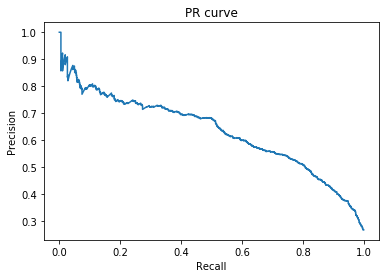





KNeighborsClassifier


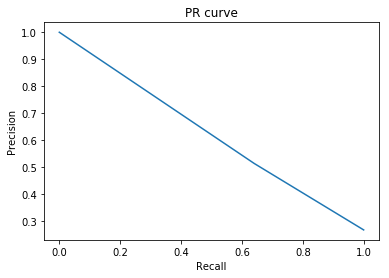





SVC


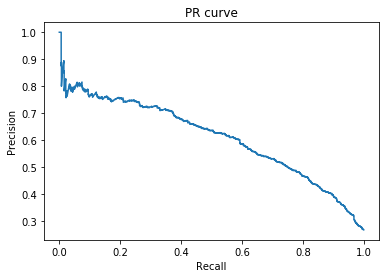





RandomForestClassifier


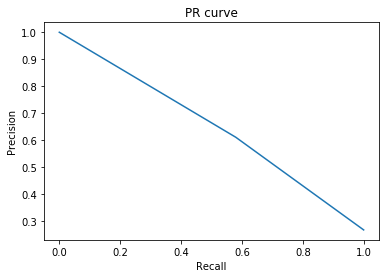

In [0]:
fpr_s = []
tpr_s = []
y_scores = []
model_precisions = []
model_recalls = []
model_thresholds = []
model_names = [type(model).__name__ for model in best_models]

# plotting different curves
for model in best_models:
    print(type(model).__name__)
    y_score = yscores(model, X_train, y_train)
    y_scores.append(y_score)
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_score)
    model_precisions.append(precisions)
    model_recalls.append(recalls)
    model_thresholds.append(thresholds)
    precision_vs_recall(precisions, recalls)
    fpr, tpr, _ = roc_curve(y_train, y_score)
    fpr_s.append(fpr)
    tpr_s.append(tpr)
    print('\n\n\n')

<h4>PR vs Threshold</h4>

SGDClassifier


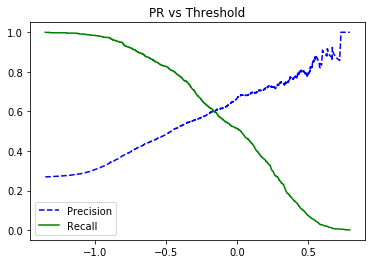





KNeighborsClassifier


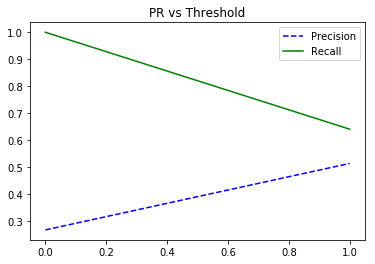





SVC


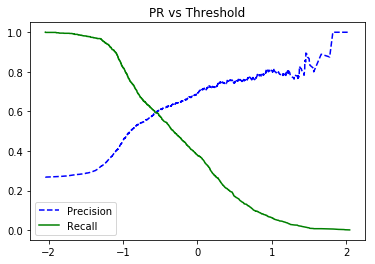





RandomForestClassifier


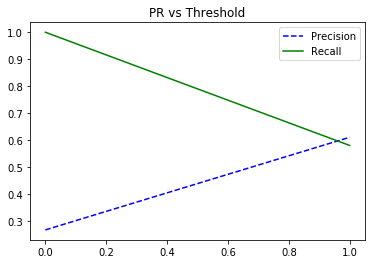

In [0]:
for i, (precisions, recalls, thresholds) in enumerate(zip(model_precisions, model_recalls, model_thresholds)):
    print(type(best_models[i]).__name__)
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    print('\n\n\n')

<h4>ROC curve</h4>

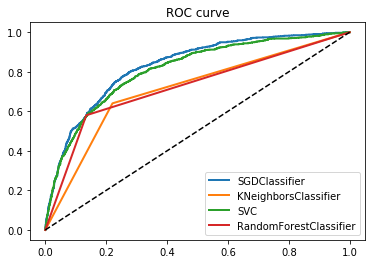

In [0]:
plot_roc_curve(fpr_s, tpr_s, model_names)

The ROC curve of SGDClassifier and SVC is having larger area under the curve so they will perform better. The last check will be with the test set.

<h4>Transforming the test set</h4>

In [0]:
# transform the test set
validation_customers = final_pipeline.transform(customers_test_set)
validation_customers = np.delete(validation_customers, [4, 7, 16], axis=1)

# seperate the labels from the data
X_test = validation_customers[:, :-1]
y_test = validation_customers[:, -1]

<h3>Final score: <small>Test set predictions</small></h3>

In [0]:
test_scores = []

for model in best_models:
    y_test_pred = model.predict(X_test)
    test_scores.append(f1_score(y_test, y_test_pred))

fig, ax = plt.subplots()
y_pos = np.arange(len(best_models))
ax.barh(y_pos, test_scores, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(model_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('f1 score')

plt.show()

<h2>Final Conclusions</h2>

SGD Classifier performs the best among the selected classifiers, having the highest f1 score. 

In [0]:
print("Accuracy of SGD Classifier:", accuracies[0])